# DATA620: Project 3 - Gender Identification

## Homework Team 3: David Simbandumwe, Eric Lehmphul and Lidiia Tronina

Your project should be submitted (as an Jupyter Notebook via GitHub). The team members should all submit a link to the same repository. If any of you don't submit the link to GitHub, I will assume you didn't collaborate.
Using any of the three classifiers described in chapter 6 of Natural Language Processing with Python, and any features you can think of, build the best name gender classifier you can. Begin by splitting the Names Corpus into three subsets: 500 words for the test set, 500 words for the dev-test set, and the remaining 6900 words for the training set. Then, starting with the example name gender classifier, make incremental improvements. Use the dev-test set to check your progress. Once you are satisfied with your classifier, check its final performance on the test set. How does the performance on the test set compare to the performance on the dev-test set? Is this what you'd expect?

### Load Required Packages

In [47]:
import nltk
from nltk.corpus import names
from nltk.classify import apply_features
from nltk.probability import FreqDist
import pandas as pd
import random
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

### Objects

In [49]:
class GenderAnalysis():
    
    def __init__(self):
       
        # Import and Lable Names
        self._names_lst = ([(name, 'male') for name in names.words('male.txt')] +
                [(name, 'female') for name in names.words('female.txt')])
        random.shuffle(self._names_lst)

        # Split Corpus
        self._train_names = self._names_lst[1000:]
        self._devtest_names = self._names_lst[500:1000]
        self._test_names = self._names_lst[:500]
    
        # apply features training, devtest and test corpus
        self._train_set = apply_features(self.gender_features, self._train_names)
        self._devtest_set = apply_features(self.gender_features, self._devtest_names)
        self._test_set = apply_features(self.gender_features, self._test_names)
        
        self._classifier = None
        
    
    # generate features
    def gender_features(self, name):
        features = {}
        features["suffix1"] = name[-1].lower()
        return features
    
    
    # get features dataframe 
    def get_names_features(self):
        # analyze data
        df = pd.DataFrame(self._names_lst, columns=['name','gender'])
        return df
    
    
    # get names that can be both male and female
    def ambiguous_features(self):
        # analyze data
        df = pd.DataFrame(self._names_lst, columns=['name','gender'])
        df2 = df.groupby(['name'])['name'].count().reset_index(name='count').sort_values(
            ['count'], ascending=False)
        df2 = df2[df2['count']>1]
        name_df = pd.merge(df,df2,how="inner", on=["name"])
        return name_df
    
    
    def train(self):
        self._classifier = nltk.NaiveBayesClassifier.train(self._train_set)
        
        
    def get_DevTest_accuracty(self):     
        return nltk.classify.accuracy(self._classifier, self._devtest_set)
        

    def show_Inform_feature(self, n=20):
        self._classifier.show_most_informative_features(n)
        
        
    def get_Errors(self):
        errors = []
        for (name, tag) in self._devtest_names:
            guess = self._classifier.classify(self.gender_features(name))
            if guess != tag:
                errors.append((tag, guess, name))                
          
        errors_df = pd.DataFrame(errors, columns=['tag', 'guess', 'name'])
        return errors_df
    
    
    def print_Errors(self):
        for (tag, guess, name) in sorted(errors):
            print ('correct=%-8s guess=%-8s name=%-30s' % (tag, guess, name))

      
    

In [50]:
class GenderAnalysis2(GenderAnalysis):
    
    def gender_features(self, name):
        features = {}
        #features["firstletter"] = name[0].lower()
        features["suffix1"] = name[-1].lower()
        features["suffix2"] = name[-2].lower()

        return features

    
    
class GenderAnalysis3(GenderAnalysis):
    
    def gender_features(self, name):
        features = {}
        features["firstletter"] = name[0].lower()
        features["suffix1"] = name[-1].lower()
        features["suffix2"] = name[-2].lower()

        return features

### Analysis of Names Corpus

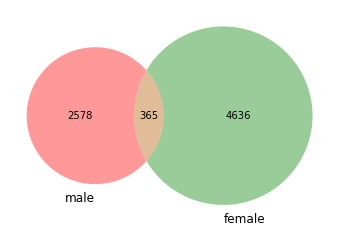

In [51]:
ga1 = GenderAnalysis()

# Use the venn2 function
df = ga1.get_names_features()
s1 = set(df[df['gender'] == 'male']['name'])
s2 = set(df[df['gender'] == 'female']['name'])
venn2([s1, s2], set_labels = ('male', 'female'))
plt.show()

In [52]:
print('Size Train Set',len(ga1._train_names))
print('Size Development Set',len(ga1._devtest_names))
print('Size Test Set',len(ga1._test_names))



Size Train Set 6944
Size Development Set 500
Size Test Set 500


### Feature 1

In [53]:
ga1.train()
print(ga1.get_DevTest_accuracty())
e_df = ga1.get_Errors()
e_df

0.758


,tag,guess,name
0,female,male,Jill
1,male,female,Binky
2,male,female,Georgia
3,female,male,Enid
4,male,female,Roni
...,...,...,...
116,female,male,Jaquelin
117,female,male,Harriot
118,male,female,Rikki
119,female,male,Colleen


In [54]:
ga1.show_Inform_feature()

Most Informative Features
                 suffix1 = 'a'            female : male   =     33.2 : 1.0
                 suffix1 = 'k'              male : female =     30.3 : 1.0
                 suffix1 = 'f'              male : female =     13.4 : 1.0
                 suffix1 = 'v'              male : female =     13.2 : 1.0
                 suffix1 = 'p'              male : female =     10.0 : 1.0
                 suffix1 = 'd'              male : female =      9.7 : 1.0
                 suffix1 = 'o'              male : female =      9.4 : 1.0
                 suffix1 = 'm'              male : female =      8.2 : 1.0
                 suffix1 = 'r'              male : female =      6.5 : 1.0
                 suffix1 = 'w'              male : female =      4.9 : 1.0
                 suffix1 = 'g'              male : female =      4.8 : 1.0
                 suffix1 = 't'              male : female =      4.4 : 1.0
                 suffix1 = 's'              male : female =      4.3 : 1.0

### Feature 2

In [55]:
ga2 = GenderAnalysis2()
ga2.train()
print(ga2.get_DevTest_accuracty())
e_df = ga2.get_Errors()
e_df

0.78


,tag,guess,name
0,male,female,Toddie
1,female,male,Annabel
2,male,female,Terri
3,female,male,Bird
4,female,male,Laural
...,...,...,...
105,female,male,Laureen
106,male,female,Mika
107,male,female,Wally
108,female,male,Ingeberg


In [56]:
ga2.show_Inform_feature()

Most Informative Features
                 suffix1 = 'a'            female : male   =     33.0 : 1.0
                 suffix1 = 'k'              male : female =     31.0 : 1.0
                 suffix1 = 'f'              male : female =     26.8 : 1.0
                 suffix1 = 'p'              male : female =     10.6 : 1.0
                 suffix1 = 'd'              male : female =     10.2 : 1.0
                 suffix1 = 'v'              male : female =      9.2 : 1.0
                 suffix1 = 'o'              male : female =      8.2 : 1.0
                 suffix2 = 'u'              male : female =      8.0 : 1.0
                 suffix1 = 'm'              male : female =      7.3 : 1.0
                 suffix2 = 'o'              male : female =      6.8 : 1.0
                 suffix1 = 'r'              male : female =      6.6 : 1.0
                 suffix1 = 'z'              male : female =      5.6 : 1.0
                 suffix1 = 'w'              male : female =      4.8 : 1.0

### Feature 3

In [57]:
ga3 = GenderAnalysis3()
ga3.train()
print(ga3.get_DevTest_accuracty())
e_df = ga3.get_Errors()
e_df

0.754


,tag,guess,name
0,female,male,Evaleen
1,female,male,Nicol
2,male,female,Benny
3,male,female,Sunny
4,female,male,Chrysler
...,...,...,...
118,female,male,Mabel
119,female,male,Joleen
120,female,male,Kessiah
121,male,female,Deryl


In [58]:
ga3.show_Inform_feature()

Most Informative Features
                 suffix1 = 'a'            female : male   =     33.3 : 1.0
                 suffix1 = 'k'              male : female =     31.4 : 1.0
                 suffix1 = 'f'              male : female =     17.4 : 1.0
                 suffix1 = 'p'              male : female =     10.6 : 1.0
                 suffix1 = 'd'              male : female =     10.4 : 1.0
                 suffix1 = 'm'              male : female =      9.3 : 1.0
                 suffix1 = 'v'              male : female =      9.2 : 1.0
                 suffix2 = 'u'              male : female =      7.9 : 1.0
                 suffix2 = 'o'              male : female =      7.8 : 1.0
                 suffix1 = 'o'              male : female =      7.7 : 1.0
                 suffix1 = 'r'              male : female =      7.2 : 1.0
                 suffix1 = 'z'              male : female =      7.2 : 1.0
                 suffix1 = 'w'              male : female =      5.5 : 1.0